# Heart Disease Prediction - Explainable AI (XAI) Analysis

This notebook implements and demonstrates XAI techniques for heart disease prediction model interpretability.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from lime import lime_tabular
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Set up plotting
plt.style.use('ggplot')
sns.set(style="whitegrid")
%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [11]:
# Load and prepare dataset
file_path = 'C:/Users/DELL/Desktop/heart-xai-chatbot/data/heart.csv'
df = pd.read_csv(file_path)
print(f"Dataset loaded with shape: {df.shape}")

# Separate features and target
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

Dataset loaded with shape: (918, 12)


In [12]:
# Encode categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Define feature names
feature_names = [
    'Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
    'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'
]

In [16]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Load model (or train one if you don't have it)
try:
    model = joblib.load('C:/Users/DELL/Desktop/heart-xai-chatbot/backend/model/model.pkl')
    print("Model loaded successfully")
except:
    print("Model file not found, training a new one...")
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    print("New model trained")

    


Model loaded successfully


In [18]:
print(model)


['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']


In [27]:
X[col] = le.fit_transform(X[col])


SHAPP model


In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import joblib
from pathlib import Path

# Paths
base_path = Path("C:/Users/DELL/Desktop/heart-xai-chatbot")
data_path = base_path / "data/heart.csv"
model_dir = base_path / "backend/model"
encoder_dir = model_dir / "encoders"
scaler_path = model_dir / "scaler.pkl"
model_path = model_dir / "model.pkl"

# Create directories
model_dir.mkdir(parents=True, exist_ok=True)
encoder_dir.mkdir(parents=True, exist_ok=True)

# Load dataset
df = pd.read_csv(data_path)

# Separate features and target
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

# Handle missing values
if X.isnull().sum().any():
    X = X.fillna(X.mean())

# Encode categorical variables
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le
    # Save each encoder
    joblib.dump(le, encoder_dir / f"{col}_encoder.pkl")

# Save feature names
feature_names = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol',
                 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 
                 'Oldpeak', 'ST_Slope']
X = X[feature_names]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, scaler_path)  # Save scaler

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Save model
joblib.dump(model, model_path)


Accuracy: 0.8804347826086957
ROC AUC: 0.9438645466682849
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86        77
           1       0.90      0.90      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



['C:\\Users\\DELL\\Desktop\\heart-xai-chatbot\\backend\\model\\model.pkl']

## 2. Local Explanations with SHAP

Let's examine individual predictions to understand how the model arrives at specific decisions.

In [32]:
# Select a sample patient for explanation
sample_idx = 50  # Can be changed to examine different patients
sample_X = X.iloc[sample_idx:sample_idx+1]
sample_X_scaled = scaler.transform(sample_X)
true_label = y.iloc[sample_idx]
prediction = model.predict(sample_X_scaled)[0]
prediction_proba = model.predict_proba(sample_X_scaled)[0, 1]

print(f"Sample patient data:\n{sample_X}")
print(f"True label: {'Heart Disease' if true_label == 1 else 'No Heart Disease'}")
print(f"Predicted: {'Heart Disease' if prediction == 1 else 'No Heart Disease'} with {prediction_proba:.4f} probability")

Sample patient data:
    Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
50   50    1              0        130          233          0           1   

    MaxHR  ExerciseAngina  Oldpeak  ST_Slope  
50    121               1      2.0         1  
True label: Heart Disease
Predicted: Heart Disease with 1.0000 probability


<Figure size 2000x300 with 0 Axes>

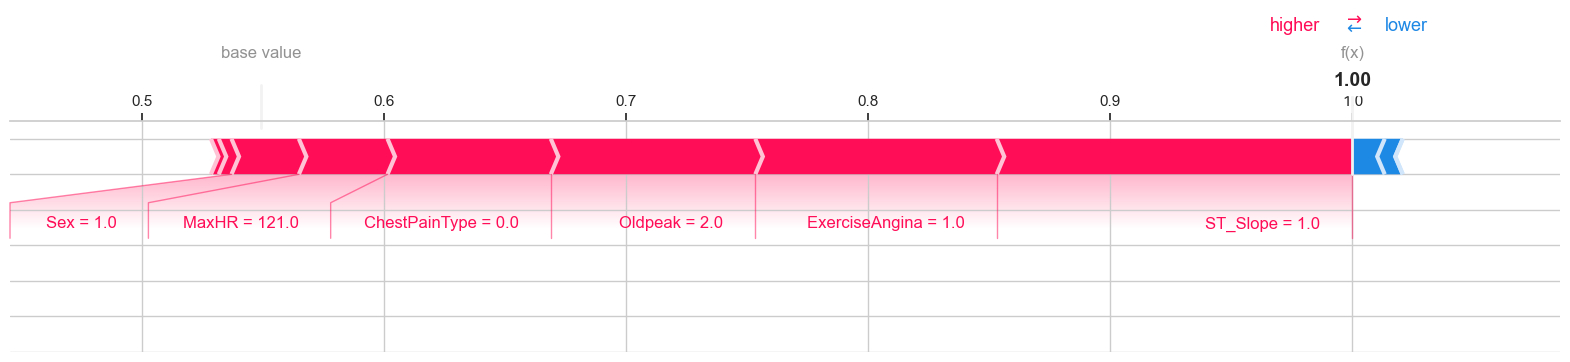

In [34]:
explainer = shap.TreeExplainer(model)

# SHAP values for the sample patient
plt.figure(figsize=(20, 3))
shap_values_sample = explainer.shap_values(sample_X_scaled)

# For binary classification, some models return a list
if isinstance(shap_values_sample, list):
    shap_values_sample = shap_values_sample[1]  # For the positive class

shap.force_plot(explainer.expected_value[1], 
                shap_values_sample, 
                sample_X, 
                feature_names=feature_names, 
                matplotlib=True,
                show=True)

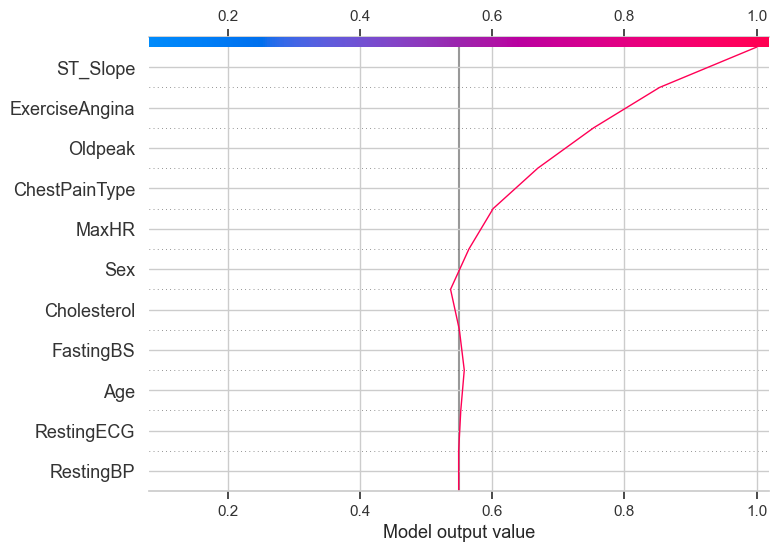

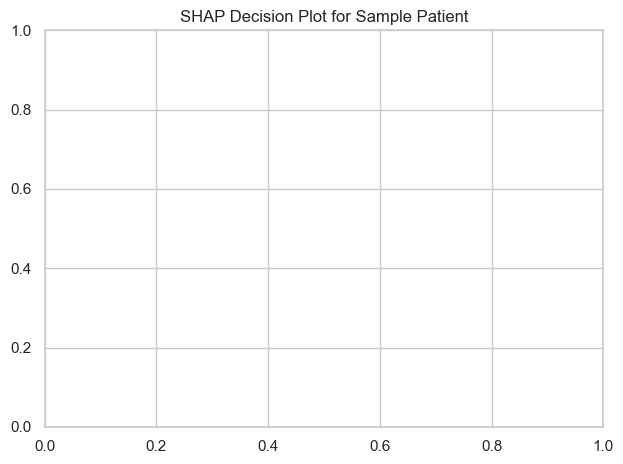

In [35]:
# Convert force plot to decision plot
plt.figure(figsize=(12, 10))
shap.decision_plot(explainer.expected_value if not hasattr(explainer, 'expected_value') else explainer.expected_value[1], 
                   shap_values_sample, 
                   feature_names=feature_names)
plt.title('SHAP Decision Plot for Sample Patient')
plt.tight_layout()
plt.show()

## 3. LIME Explanations

LIME (Local Interpretable Model-agnostic Explanations) creates a simple, interpretable model that approximates the original model's behavior locally.

In [36]:
# Initialize LIME explainer
lime_explainer = lime_tabular.LimeTabularExplainer(
    X_scaled,
    feature_names=feature_names,
    class_names=['No Heart Disease', 'Heart Disease'],
    mode='classification'
)

<Figure size 1000x800 with 0 Axes>

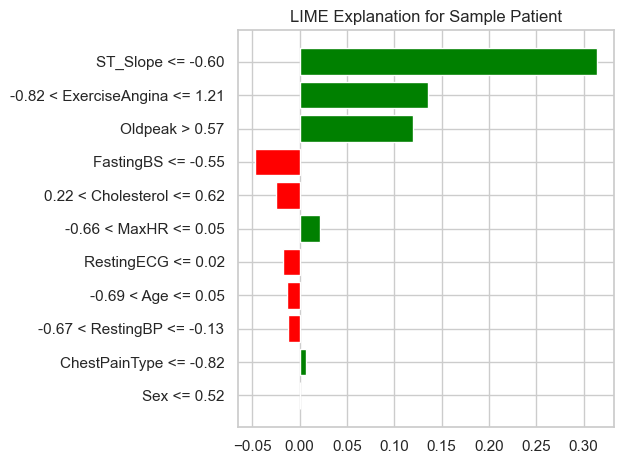

In [37]:
# Generate LIME explanation for sample patient
lime_exp = lime_explainer.explain_instance(
    sample_X_scaled[0],
    model.predict_proba,
    num_features=len(feature_names),
    top_labels=1
)

# Plot LIME explanation
plt.figure(figsize=(10, 8))
lime_exp.as_pyplot_figure(label=1)  # For the positive class
plt.title('LIME Explanation for Sample Patient')
plt.tight_layout()
plt.show()

## 4. Comparing XAI Techniques

Now let's compare the explanations from both SHAP and LIME for the same patient.

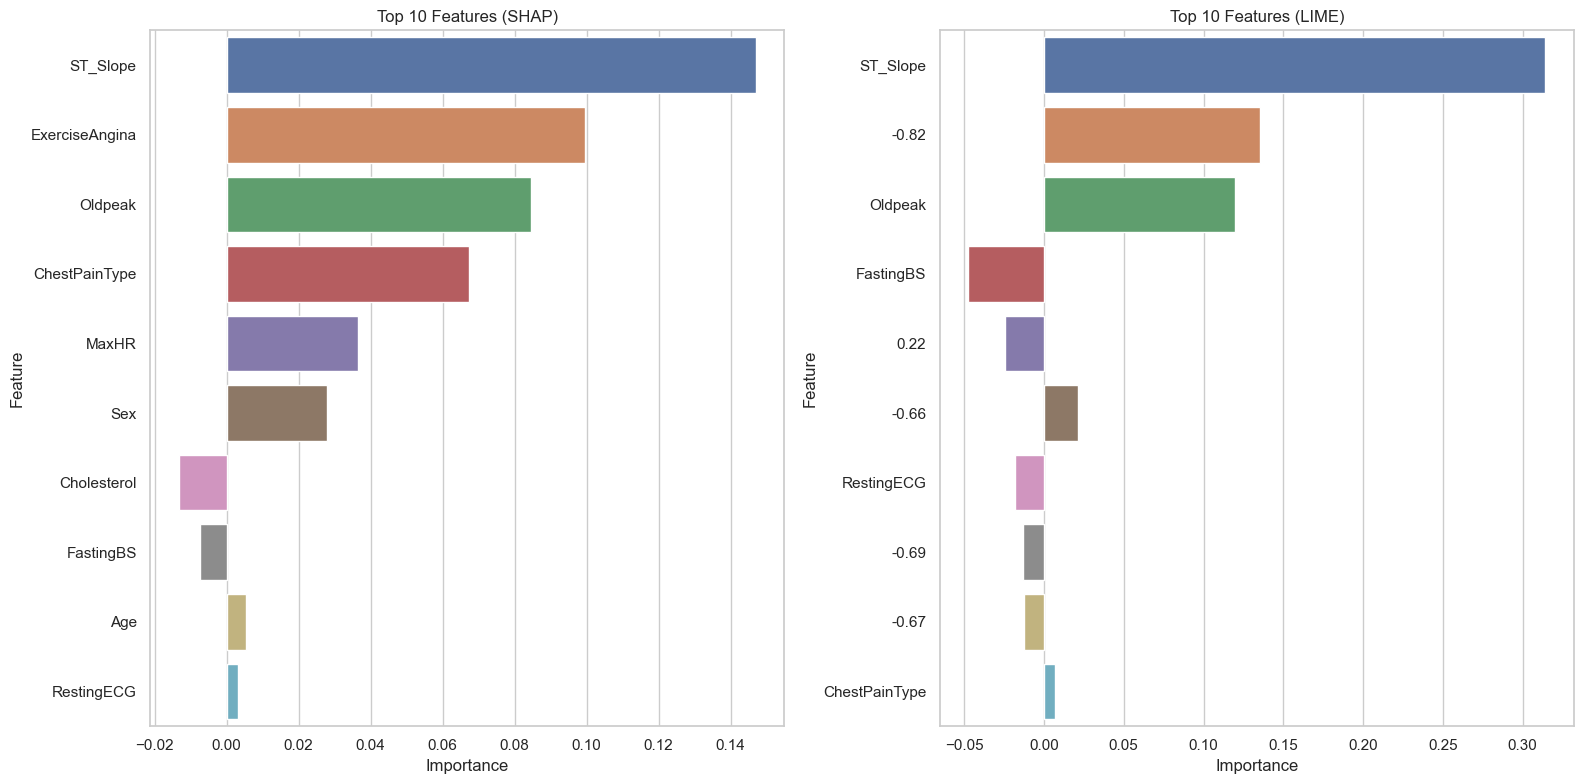

In [38]:
# Extract feature importance from LIME explanation
lime_importance = dict(lime_exp.as_list(label=1))
lime_df = pd.DataFrame({
    'Feature': [item.split(' ')[0] for item in lime_importance.keys()],
    'Importance': list(lime_importance.values())
}).sort_values(by='Importance', key=abs, ascending=False)

# Extract SHAP values for the sample
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': shap_values_sample[0]
}).sort_values(by='Importance', key=abs, ascending=False)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# SHAP plot
sns.barplot(x='Importance', y='Feature', data=shap_df.head(10), ax=axes[0])
axes[0].set_title('Top 10 Features (SHAP)')

# LIME plot
sns.barplot(x='Importance', y='Feature', data=lime_df.head(10), ax=axes[1])
axes[1].set_title('Top 10 Features (LIME)')

plt.tight_layout()
plt.show()

## 5. Implementing a Function for Explanation

Finally, let's develop a function that can be used in the backend API to generate explanations for any patient.

In [39]:
def generate_explanation(patient_data, model, scaler, feature_names):
    """
    Generate SHAP and LIME explanations for a patient's prediction.
    
    Args:
        patient_data (pd.DataFrame): Patient features as a DataFrame
        model: Trained ML model
        scaler: Feature scaler used during training
        feature_names (list): List of feature names
        
    Returns:
        dict: Dictionary containing prediction and explanations
    """
    # Scale the input data
    patient_data_scaled = scaler.transform(patient_data)
    
    # Make prediction
    prediction = model.predict(patient_data_scaled)[0]
    probability = model.predict_proba(patient_data_scaled)[0, 1]
    
    # Initialize SHAP explainer
    if hasattr(model, 'feature_importances_'):
        explainer = shap.TreeExplainer(model)
    else:
        # Use a subset of the training data as background
        background_data = shap.sample(X_scaled, 100)
        explainer = shap.KernelExplainer(model.predict_proba, background_data)
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(patient_data_scaled)
    
    # For binary classification, some models return a list
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # For the positive class
    
    # Get SHAP values as dictionary
    shap_dict = {feature: float(value) for feature, value in zip(feature_names, shap_values[0])}
    
    # Initialize LIME explainer
    lime_explainer = lime_tabular.LimeTabularExplainer(
        X_scaled,
        feature_names=feature_names,
        class_names=['No Heart Disease', 'Heart Disease'],
        mode='classification'
    )
    
    # Generate LIME explanation
    lime_exp = lime_explainer.explain_instance(
        patient_data_scaled[0],
        model.predict_proba,
        num_features=len(feature_names),
        top_labels=1
    )
    
    # Extract LIME explanation as list of (feature, weight) tuples
    lime_list = lime_exp.as_list(label=1)
    lime_explanation = [{'feature': item[0], 'weight': float(item[1])} for item in lime_list]
    
    # Get global feature importance if available
    if hasattr(model, 'feature_importances_'):
        feature_importance = {feature: float(importance) 
                              for feature, importance in zip(feature_names, model.feature_importances_)}
    else:
        # For models without built-in feature importance (e.g., Logistic Regression)
        feature_importance = {feature: float(abs(coef)) 
                              for feature, coef in zip(feature_names, model.coef_[0])}
    
    # Create explanation dictionary
    explanation = {
        'prediction': int(prediction),
        'probability': float(probability),
        'shap_values': shap_dict,
        'feature_importance': feature_importance,
        'lime_explanation': lime_explanation,
        'expected_value': float(explainer.expected_value if not hasattr(explainer, 'expected_value') 
                              else explainer.expected_value[1])
    }
    
    return explanation

In [40]:
# Test the explanation function with our sample patient
explanation = generate_explanation(sample_X, model, scaler, feature_names)

# Print the explanation in a readable format
print(f"Prediction: {'Heart Disease' if explanation['prediction'] == 1 else 'No Heart Disease'}")
print(f"Probability: {explanation['probability']:.4f}")
print("\nTop 5 SHAP values:")
for feature, value in sorted(explanation['shap_values'].items(), key=lambda x: abs(x[1]), reverse=True)[:5]:
    print(f"  {feature}: {value:.4f}")
    
print("\nTop 5 LIME features:")
for item in sorted(explanation['lime_explanation'], key=lambda x: abs(x['weight']), reverse=True)[:5]:
    print(f"  {item['feature']}: {item['weight']:.4f}")
    
print("\nTop 5 global feature importance:")
for feature, value in sorted(explanation['feature_importance'].items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  {feature}: {value:.4f}")

Prediction: Heart Disease
Probability: 1.0000

Top 5 SHAP values:
  ST_Slope: 0.1469
  ExerciseAngina: 0.0997
  Oldpeak: 0.0845
  ChestPainType: 0.0675
  MaxHR: 0.0366

Top 5 LIME features:
  ST_Slope <= -0.60: 0.3234
  -0.82 < ExerciseAngina <= 1.21: 0.1370
  Oldpeak > 0.57: 0.1317
  FastingBS <= -0.55: -0.0499
  0.22 < Cholesterol <= 0.62: -0.0291

Top 5 global feature importance:
  ST_Slope: 0.2413
  Oldpeak: 0.1231
  Cholesterol: 0.1072
  MaxHR: 0.1038
  ExerciseAngina: 0.1000


In [42]:
# Save the explanation function for use in the backend
import inspect
function_code = inspect.getsource(generate_explanation)

with open('C:/Users/DELL/Desktop/heart-xai-chatbot/backend/model/explainability.py', 'w') as f:
    f.write("import pandas as pd\n")
    f.write("import numpy as np\n")
    f.write("import shap\n")
    f.write("from lime import lime_tabular\n\n")
    f.write(function_code)

print("Explanation function saved to '../backend/model/explainability.py'")

Explanation function saved to '../backend/model/explainability.py'


## XAI Analysis Summary

In this notebook, we've implemented and analyzed several Explainable AI techniques for our heart disease prediction model:

1. **SHAP (Global Explanations)**: We identified which features are most important overall for predicting heart disease.

2. **SHAP (Local Explanations)**: We examined how specific feature values contribute to individual predictions through force plots and decision plots.

3. **LIME Explanations**: We generated local explanations using LIME, which creates simple approximations of the model for individual predictions.

4. **Comparison**: We compared SHAP and LIME explanations, noting similarities and differences in their interpretations.

5. **API Integration**: We created a reusable function that can be integrated into our backend API to generate explanations for any new patient.

These XAI techniques provide transparency into our model's decision-making process, helping both healthcare providers and patients understand the factors driving heart disease risk predictions.